In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
from impala.dbapi import connect

conn=connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor=conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('avgratings',), ('employees',), ('flight_2007',), ('flight_data_2007',), ('movie_names',), ('movies',), ('names',), ('ratings',), ('topmovieids',), ('u',)]


In [43]:
#Adjust Tez Value
cursor.execute("SET hive.tez.container.size=512")
cursor.execute("SET tez.runtime.io.sort.mb=128")

In [15]:
###1.Delay Patterns
#Times of Day
query="""
SELECT
  CASE 
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2159 THEN 'Evening'
    ELSE 'LateNight'
  END AS TimeOfDay,
  AVG(DepDelay) AS AvgDepDelay,
  AVG(ArrDelay) AS AvgArrDelay
FROM flight_2007
WHERE Cancelled = 0
GROUP BY 
  CASE 
    WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
    WHEN CRSDepTime BETWEEN 1200 AND 1659 THEN 'Afternoon'
    WHEN CRSDepTime BETWEEN 1700 AND 2159 THEN 'Evening'
    ELSE 'LateNight'
  END
"""

cursor.execute(query)

results=cursor.fetchall()

for row in results:
    print(row)

('LateNight', 11.89777314039375, 9.94444788377804)
('Morning', 5.363053769076088, 4.182838374713285)
('Afternoon', 13.301440344056696, 12.390916334870901)
('Evening', 18.648234699762124, 17.095224934877216)


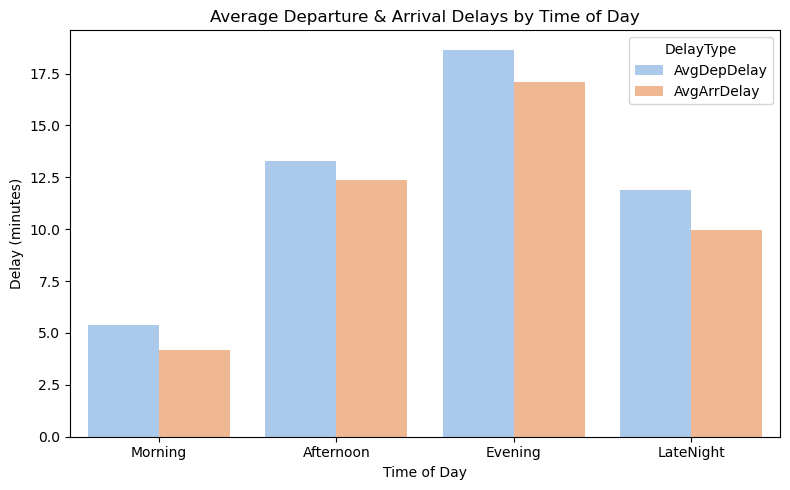

In [65]:
#Visualization
df = pd.DataFrame(results, columns=['TimeOfDay', 'AvgDepDelay', 'AvgArrDelay'])

df['TimeOfDay'] = pd.Categorical(df['TimeOfDay'], categories=['Morning', 'Afternoon', 'Evening', 'LateNight'], ordered=True)
df = df.sort_values('TimeOfDay')

df_melted = df.melt(id_vars='TimeOfDay', value_vars=['AvgDepDelay', 'AvgArrDelay'], var_name='DelayType', value_name='Delay')

plt.figure(figsize=(8, 5))
sns.barplot(data=df_melted, x='TimeOfDay', y='Delay', hue='DelayType', palette='pastel')
plt.title('Average Departure & Arrival Delays by Time of Day')
plt.ylabel('Delay (minutes)')
plt.xlabel('Time of Day')
plt.tight_layout()
plt.show()

In [34]:
#Days of Week
query="""
SELECT DayOfWeek, AVG(ArrDelay) AS AvgArrDelay
FROM flight_2007
WHERE Cancelled = 0
GROUP BY DayOfWeek
ORDER BY AvgArrDelay DESC
"""

cursor.execute(query)

results2=cursor.fetchall()

for row in results2:
    print(row)

(5, 13.067675000697863)
(4, 12.685980155261941)
(1, 10.513502556550229)
(7, 10.32957740663109)
(3, 9.962943847767281)
(2, 8.263684434009868)
(6, 5.846600031017031)


C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\772258209.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DayName', y='AvgArrDelay', data=df, palette='Blues_d')


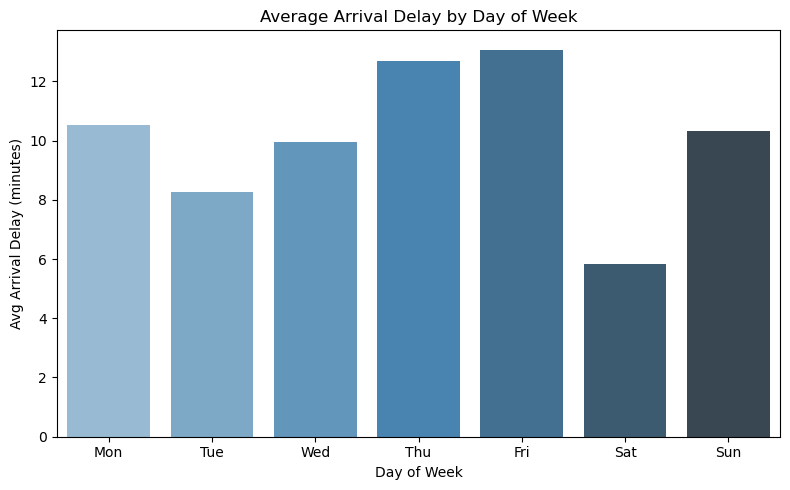

In [61]:
#Visualization
df = pd.DataFrame(results2, columns=['DayOfWeek', 'AvgArrDelay'])

day_map = {
    1: 'Mon',
    2: 'Tue',
    3: 'Wed',
    4: 'Thu',
    5: 'Fri',
    6: 'Sat',
    7: 'Sun'
}
df['DayName'] = df['DayOfWeek'].map(day_map)

df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=range(1, 8), ordered=True)
df = df.sort_values('DayOfWeek')

plt.figure(figsize=(8, 5))
sns.barplot(x='DayName', y='AvgArrDelay', data=df, palette='Blues_d')
plt.title('Average Arrival Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Avg Arrival Delay (minutes)')
plt.tight_layout()
plt.show()

In [32]:
#Monthly
query="""
SELECT Month, AVG(ArrDelay) AS AvgArrDelay
FROM flight_2007
WHERE Cancelled = 0
GROUP BY Month
ORDER BY AvgArrDelay DESC
"""

cursor.execute(query)

results3=cursor.fetchall()

for row in results3:
    print(row)

(12, 16.213714049846818)
(6, 16.17952800579826)
(7, 14.107679837700504)
(2, 13.51979483296776)
(8, 12.57153344196042)
(3, 10.084908470559062)
(1, 9.162151701506165)
(4, 8.516229825822615)
(5, 7.037888681043307)
(10, 6.5082592714725775)
(11, 4.793344024722863)
(9, 3.7494980749698845)


C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\495162344.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='MonthName', y='AvgArrDelay', palette='Oranges')


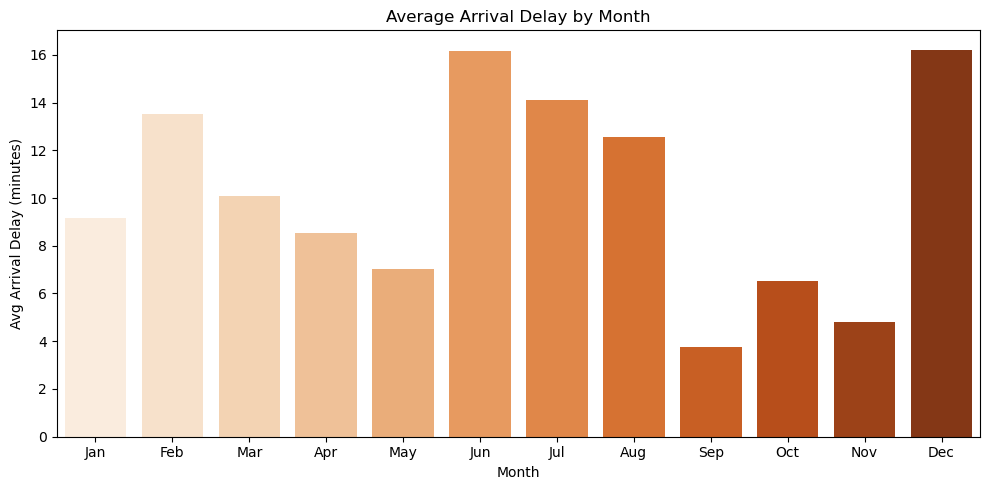

In [63]:
#Visualization
df = pd.DataFrame(results3, columns=['Month', 'AvgArrDelay'])

month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['MonthName'] = df['Month'].map(month_map)

df['Month'] = pd.Categorical(df['Month'], categories=range(1, 13), ordered=True)
df = df.sort_values('Month')

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='MonthName', y='AvgArrDelay', palette='Oranges')
plt.title('Average Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Avg Arrival Delay (minutes)')
plt.tight_layout()
plt.show()

In [36]:
#Delay Factors
query="""
SELECT 
  SUM(CarrierDelay) AS Carrier,
  SUM(WeatherDelay) AS Weather,
  SUM(NASDelay) AS NAS,
  SUM(SecurityDelay) AS Security,
  SUM(LateAircraftDelay) AS LateAircraft
FROM flight_2007
WHERE Cancelled = 0 AND (ArrDelay > 0 OR DepDelay > 0)
"""

cursor.execute(query)

results4=cursor.fetchall()

for row in results4:
    print(row)

(28808434, 5739649, 28200746, 176906, 38004942)


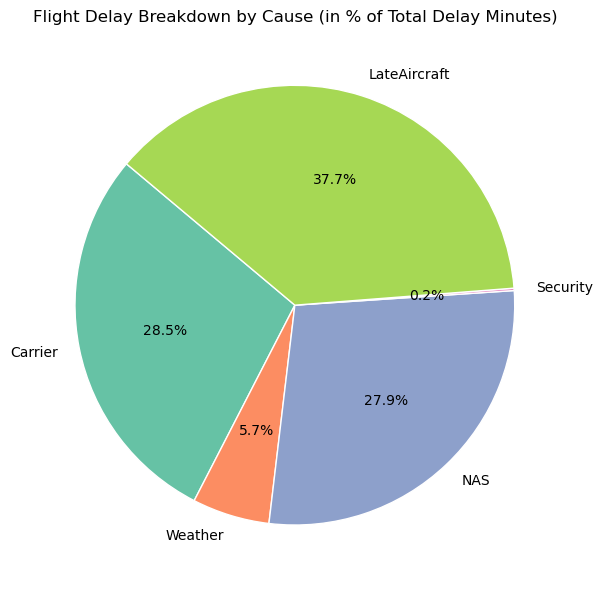

In [67]:
#Visualization
labels = ['Carrier', 'Weather', 'NAS', 'Security', 'LateAircraft']
values = list(results4[0])  # Unpack single-row tuple
df = pd.DataFrame({'Factor': labels, 'Minutes': values})

df['Percentage'] = df['Minutes'] / df['Minutes'].sum() * 100

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

plt.figure(figsize=(8, 6))
plt.pie(
    df['Minutes'],
    labels=df['Factor'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Flight Delay Breakdown by Cause (in % of Total Delay Minutes)')
plt.tight_layout()
plt.show()

C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\3284560946.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Factor', y='Minutes', data=df, palette=colors)


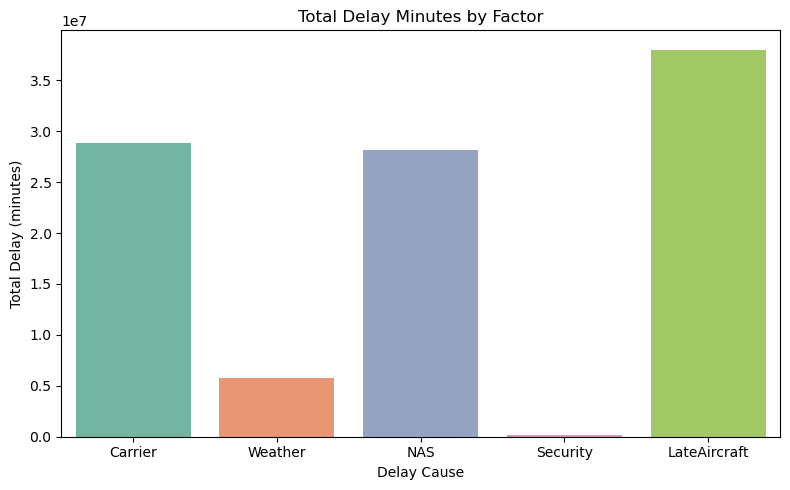

In [69]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Factor', y='Minutes', data=df, palette=colors)
plt.title('Total Delay Minutes by Factor')
plt.ylabel('Total Delay (minutes)')
plt.xlabel('Delay Cause')
plt.tight_layout()
plt.show()

In [38]:
###Cancellation Analysis
#Cancellations by reason
query="""
SELECT CancellationCode, COUNT(*) AS CancelCount
FROM flight_2007
WHERE Cancelled = 1
GROUP BY CancellationCode
"""

cursor.execute(query)

results5=cursor.fetchall()

for row in results5:
    print(row)

('B', 61935)
('D', 39)
('C', 31995)
('A', 66779)


In [73]:
#After refering to some references, the CancellationCode column means:
#Code	Reason
#A	Carrier (airline)
#B	Weather
#C	NAS (Airspace)
#D	Security

C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\1608235805.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Reason', y='Count', data=df, palette=colors)


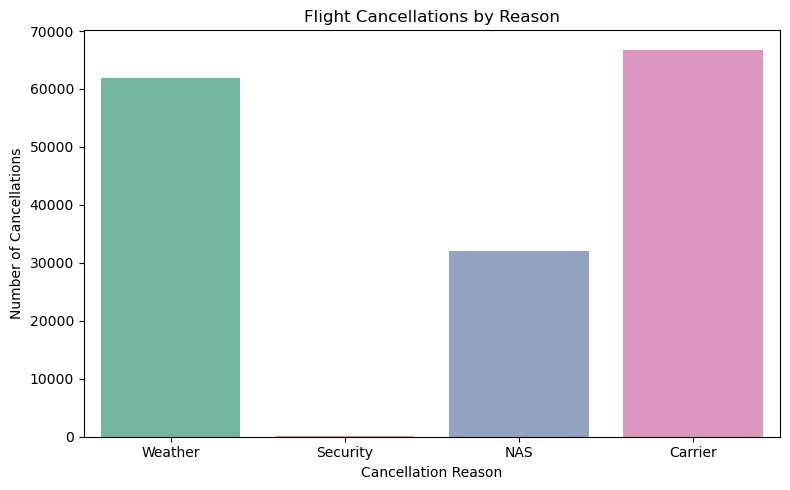

In [77]:
#Visualization
code_map = {
    'A': 'Carrier',
    'B': 'Weather',
    'C': 'NAS',
    'D': 'Security'
}

df = pd.DataFrame(results5, columns=['Code', 'Count'])
df['Reason'] = df['Code'].map(code_map)
df['Percentage'] = df['Count'] / df['Count'].sum() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x='Reason', y='Count', data=df, palette=colors)
plt.title('Flight Cancellations by Reason')
plt.ylabel('Number of Cancellations')
plt.xlabel('Cancellation Reason')
plt.tight_layout()
plt.show()

In [39]:
#Cancellations by airline
query="""
SELECT UniqueCarrier, COUNT(*) AS CancelCount
FROM flight_2007
WHERE Cancelled = 1
GROUP BY UniqueCarrier
"""

cursor.execute(query)

results6=cursor.fetchall()

for row in results6:
    print(row)

('EV', 8920)
('FL', 2602)
('UA', 11929)
('US', 8942)
('CO', 2951)
('DL', 6521)
('OH', 8851)
('AA', 17924)
('WN', 9993)
('AQ', 388)
('AS', 2563)
('OO', 14186)
('B6', 3710)
('HA', 238)
('NW', 7814)
('F9', 398)
('MQ', 22792)
('XE', 10800)
('9E', 7939)
('YV', 11287)


C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\2226642045.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Airline', y='CancelCount', palette='Set2')


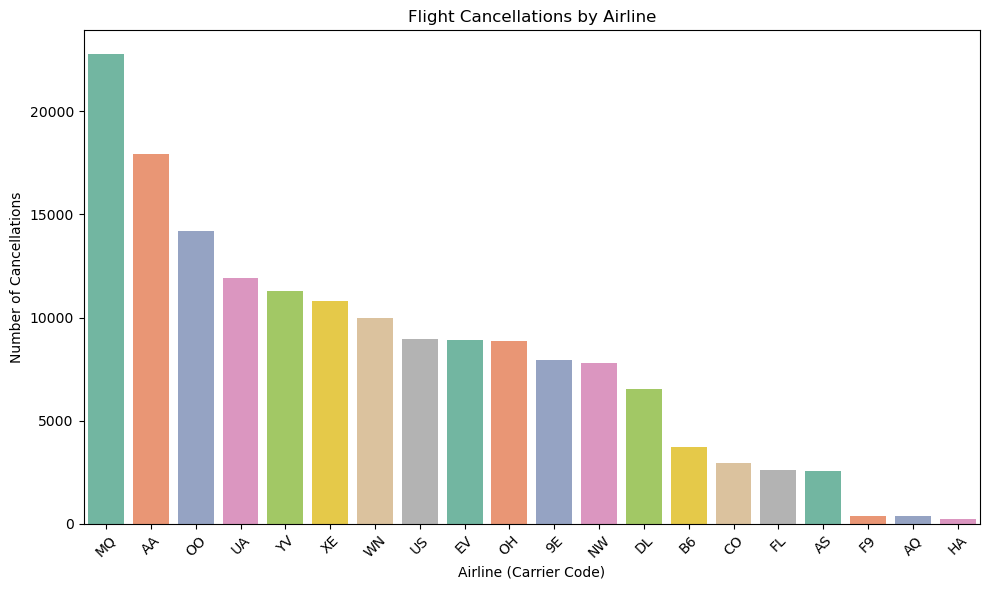

In [79]:
#Visualization
df = pd.DataFrame(results6, columns=['Airline', 'CancelCount'])
df = df.sort_values('CancelCount', ascending=False)  

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Airline', y='CancelCount', palette='Set2')
plt.title('Flight Cancellations by Airline')
plt.xlabel('Airline (Carrier Code)')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
#Cancellations by month
query="""
SELECT Month, COUNT(*) AS CancelCount
FROM flight_2007
WHERE Cancelled = 1
GROUP BY Month
"""

cursor.execute(query)

results7=cursor.fetchall()

for row in results7:
    print(row)

(5, 6841)
(11, 6279)
(1, 15777)
(4, 11138)
(7, 13506)
(2, 25465)
(9, 6507)
(8, 12295)
(3, 16877)
(6, 17243)
(10, 7327)
(12, 21493)


C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\89867702.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='MonthName', y='CancelCount', palette='Reds')


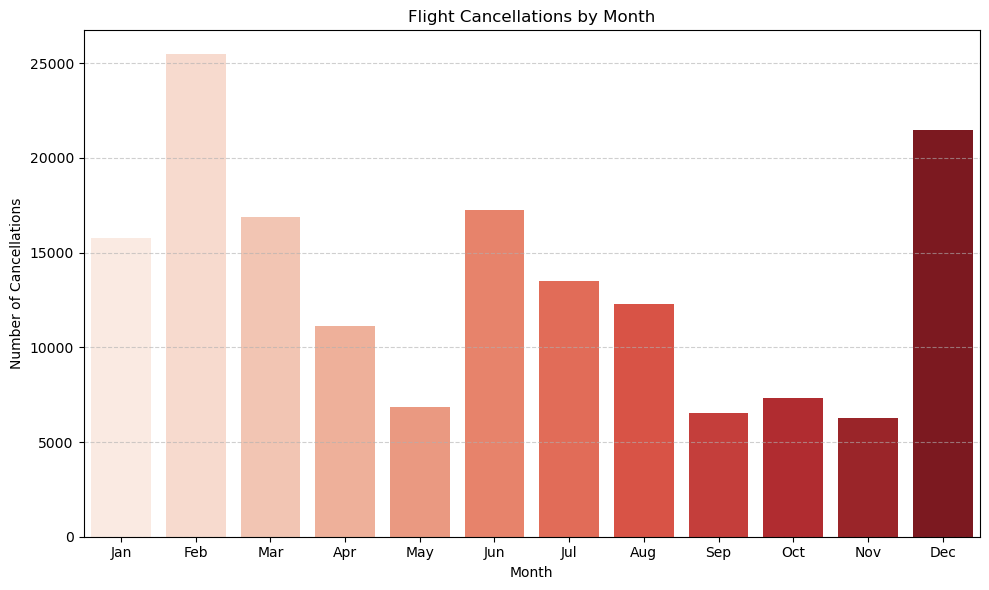

In [81]:
#Visualization
df = pd.DataFrame(results7, columns=['Month', 'CancelCount'])

month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['MonthName'] = df['Month'].map(month_map)

df['Month'] = pd.Categorical(df['Month'], categories=range(1, 13), ordered=True)
df = df.sort_values('Month')

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='MonthName', y='CancelCount', palette='Reds')
plt.title('Flight Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [47]:
#Top 10 Routes with highest average arrival delay
query="""
SELECT Origin, Dest, UniqueCarrier, AVG(ArrDelay) AS AvgArrDelay
FROM flight_2007
WHERE Cancelled = 0
GROUP BY Origin, Dest, UniqueCarrier
ORDER BY AvgArrDelay DESC
LIMIT 10
"""

cursor.execute(query)

results8=cursor.fetchall()

for row in results8:
    print(row)

('ONT', 'IAD', 'B6', 370.0)
('ELP', 'MFE', 'XE', 316.0)
('ACY', 'MYR', 'OH', 252.0)
('MDT', 'CLE', 'OH', 219.0)
('JAX', 'CMH', 'OH', 217.0)
('DCA', 'PLN', 'NW', 210.0)
('ATL', 'PBI', 'OH', 198.0)
('AVP', 'BUF', 'OH', 195.0)
('ALB', 'ATL', 'OH', 191.0)
('JFK', 'GSO', 'OH', 181.0)


C:\Users\PC02\AppData\Local\Temp\ipykernel_35428\3098955028.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


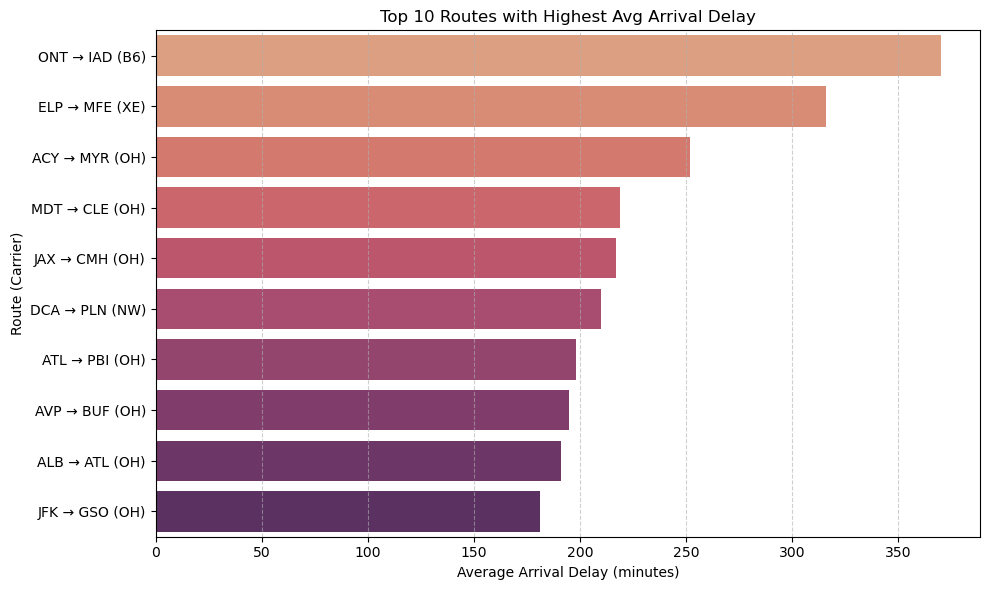

In [83]:
#Visualization
df = pd.DataFrame(results8, columns=['Origin', 'Dest', 'Carrier', 'AvgArrDelay'])

df['Route'] = df['Origin'] + ' → ' + df['Dest'] + ' (' + df['Carrier'] + ')'

df = df.sort_values('AvgArrDelay', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='AvgArrDelay',
    y='Route',
    data=df,
    palette='flare'
)

plt.title('Top 10 Routes with Highest Avg Arrival Delay')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Route (Carrier)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [51]:
#Delay reasons analysis in Top 10 Routes
query="""
SELECT
  Origin,
  Dest,
  UniqueCarrier,
  AVG(CarrierDelay) AS AvgCarrierDelay,
  AVG(WeatherDelay) AS AvgWeatherDelay,
  AVG(NASDelay) AS AvgNASDelay,
  AVG(SecurityDelay) AS AvgSecurityDelay,
  AVG(LateAircraftDelay) AS AvgLateAircraftDelay
FROM flight_2007
WHERE Cancelled = 0
  AND (Origin, Dest, UniqueCarrier) IN (
    ('ONT', 'IAD', 'B6'),
    ('ELP', 'MFE', 'XE'),
    ('ACY', 'MYR', 'OH'),
    ('MDT', 'CLE', 'OH'),
    ('JAX', 'CMH', 'OH'),
    ('DCA', 'PLN', 'NW'),
    ('ATL', 'PBI', 'OH'),
    ('AVP', 'BUF', 'OH'),
    ('ALB', 'ATL', 'OH'),
    ('JFK', 'GSO', 'OH')
  )
GROUP BY Origin, Dest, UniqueCarrier
"""

cursor.execute(query)

results9=cursor.fetchall()

for row in results9:
    print(row)

('ACY', 'MYR', 'OH', 0.0, 0.0, 30.0, 0.0, 222.0)
('ALB', 'ATL', 'OH', 191.0, 0.0, 0.0, 0.0, 0.0)
('ATL', 'PBI', 'OH', 180.0, 0.0, 18.0, 0.0, 0.0)
('AVP', 'BUF', 'OH', 0.0, 0.0, 0.0, 0.0, 195.0)
('DCA', 'PLN', 'NW', 168.0, 0.0, 42.0, 0.0, 0.0)
('ELP', 'MFE', 'XE', 0.0, 307.0, 9.0, 0.0, 0.0)
('JAX', 'CMH', 'OH', 165.0, 0.0, 52.0, 0.0, 0.0)
('JFK', 'GSO', 'OH', 173.0, 0.0, 8.0, 0.0, 0.0)
('MDT', 'CLE', 'OH', 0.0, 0.0, 219.0, 0.0, 0.0)
('ONT', 'IAD', 'B6', 0.0, 370.0, 0.0, 0.0, 0.0)


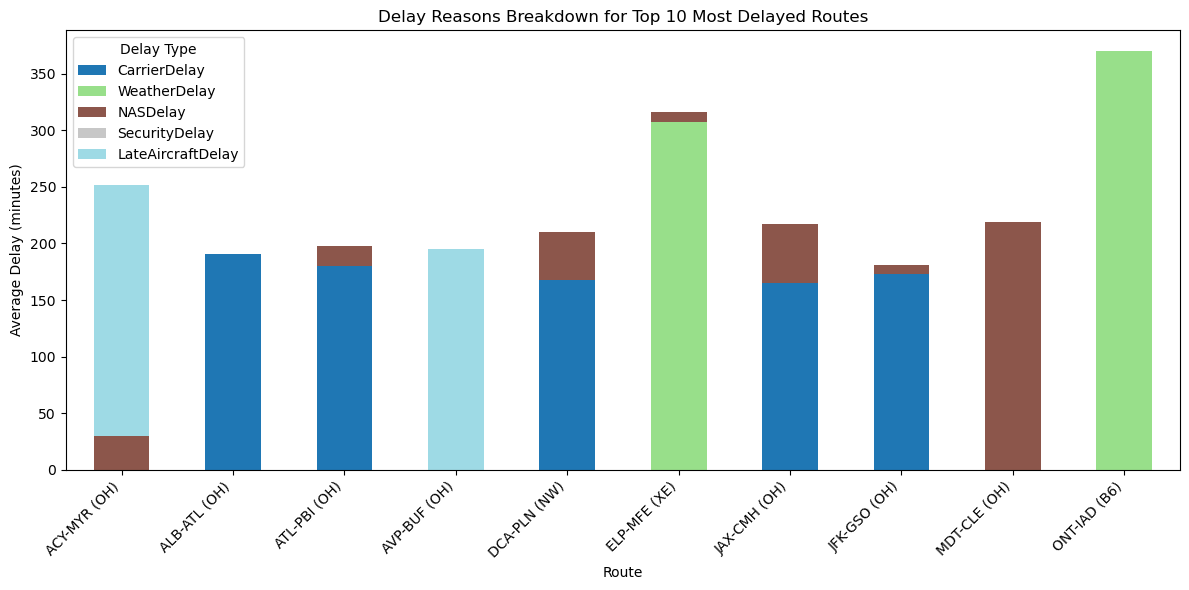

In [57]:
#Visualization
df = pd.DataFrame(results9, columns=[
    'Origin', 'Dest', 'Carrier', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
])

df['Route'] = df['Origin'] + '-' + df['Dest'] + ' (' + df['Carrier'] + ')'
df_plot = df.set_index('Route')[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']]

df_plot = df_plot.fillna(0)

df_plot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Delay Reasons Breakdown for Top 10 Most Delayed Routes')
plt.ylabel('Average Delay (minutes)')
plt.xlabel('Route')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Delay Type')
plt.show()